In [2]:
import hoomd
import freud
import schmeud
import gsd.hoomd

import matplotlib.pyplot as plt
import numpy as np

import copy
import glob
import pathlib

from monk import prep, methods, pair, render, nb, utils

In [3]:
start_temp = 1e-2
temp = 3e-4
# S = 1.0
# Sxy = 3e-3

dt = 0.05

In [4]:
outdir = pathlib.Path("/media/ian/Data2/monk/friction-old/")

In [31]:
rates = np.geomspace(1e-5, 1e-3, 9)
for i in range(10):
    for strain_rate in rates:
        steps = 40_000
        max_strain = 1.0
        strain = strain_rate * steps * dt
        if strain > 0.8:
            steps = int(0.8 / strain_rate / dt)
            strain = strain_rate * steps * dt
            assert strain < max_strain
        elif strain < 0.4:
            steps = int(0.4 / strain_rate / dt)
            strain = strain_rate * steps * dt
            assert strain < max_strain
            strain
        print(i, strain_rate, strain, steps)
        sim = prep.quick_sim(4096, 1.4, hoomd.device.GPU(), dim=2, diams=[14/12, 10/12], seed=i)
        sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=start_temp)
        integrator = hoomd.md.Integrator(dt=dt)

        nlist = hoomd.md.nlist.Cell(0.3)
        hertz = pair.bi_hertz(nlist)
        # drag = methods.SimpleViscousForce(1.0)
        integrator.forces = [hertz]

        nvt = hoomd.md.methods.NVT(hoomd.filter.All(), kT=start_temp, tau=1.0)
        integrator.methods.append(nvt)

        sim.operations.integrator = integrator
        sim.run(10_000)
        nvt.kT = temp
        sim.run(10_000)
        thermo = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
        logger = hoomd.logging.Logger()
        logger.add(thermo, quantities=["pressure", "pressure_tensor", "kinetic_temperature"])
        sim.operations.computes.clear()
        sim.operations.computes.append(thermo)

        gsd_writer = hoomd.write.GSD(hoomd.trigger.Periodic(100), outdir / f"cs-test_{i}_{strain_rate:.3e}.gsd", mode="wb", log=logger)
        sim.operations.writers.clear()
        sim.operations.writers.append(gsd_writer)

        sim.operations.updaters.clear()
        trigger = hoomd.trigger.Periodic(1)
        variant = hoomd.variant.Ramp(0, 1, sim.timestep, steps)
        old_box = sim.state.box
        new_box = copy.deepcopy(old_box)
        new_box.xy = strain
        updater = hoomd.update.BoxResize(trigger, old_box, new_box, variant)
        sim.operations.updaters.append(updater)

        # action = methods.KeepBoxTiltsSmall()
        # updater = hoomd.update.CustomUpdater(trigger, action)
        # sim.operations.updaters.append(updater)
        sim.run(steps)

0 1e-05 0.4 800000
0 1.778279410038923e-05 0.39999994651622023 449873
0 3.1622776601683795e-05 0.39999966351235855 252982
0 5.623413251903491e-05 0.39999900802114724 142262
0 0.0001 0.4 80000
0 0.00017782794100389227 0.39999727909710514 44987
0 0.00031622776601683794 0.632455532033676 40000
0 0.0005623413251903491 0.7999867692157907 28452
0 0.001 0.8 16000
1 1e-05 0.4 800000
1 1.778279410038923e-05 0.39999994651622023 449873
1 3.1622776601683795e-05 0.39999966351235855 252982
1 5.623413251903491e-05 0.39999900802114724 142262
1 0.0001 0.4 80000
1 0.00017782794100389227 0.39999727909710514 44987
1 0.00031622776601683794 0.632455532033676 40000
1 0.0005623413251903491 0.7999867692157907 28452
1 0.001 0.8 16000
2 1e-05 0.4 800000
2 1.778279410038923e-05 0.39999994651622023 449873
2 3.1622776601683795e-05 0.39999966351235855 252982
2 5.623413251903491e-05 0.39999900802114724 142262
2 0.0001 0.4 80000
2 0.00017782794100389227 0.39999727909710514 44987
2 0.00031622776601683794 0.632455532033

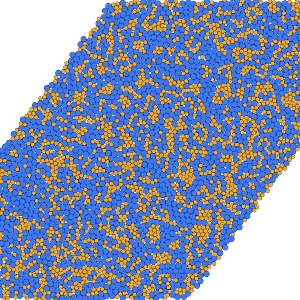

In [11]:
render.render_disk_frame(sim.state.get_snapshot())

In [5]:
files = [f.as_posix() for f in outdir.glob("cs-test_*.gsd")]
p = files[0].find("cs-test_")
file_shear_rates = [float(utils.extract_between(f, f[:p+10], ".gsd")) for f in files]

relate = {k: v for k, v in zip(files, file_shear_rates)}

from collections import defaultdict
res = defaultdict(list)
for key, val in sorted(relate.items()):
    res[val].append(key)

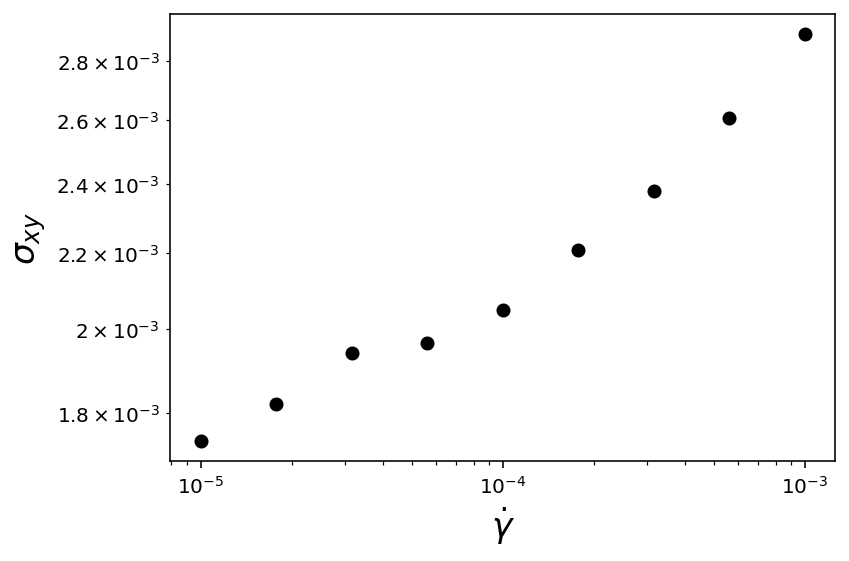

In [8]:
from scipy.ndimage import uniform_filter1d

plt.figure(tight_layout=True)

for s, fs in res.items():
    sigmas = []
    for f in fs:
        traj = gsd.hoomd.open(f, "rb")
        sigma_xy = np.array([snap.log["md/compute/ThermodynamicQuantities/pressure_tensor"][1] for snap in traj])
        sigmas.append(-sigma_xy)
    sigmas = np.mean(sigmas, axis=0)
    xy = np.array([snap.configuration.box[3] for snap in traj])
    # plt.plot(xy, uniform_filter1d(sigmas, 5))
    plt.plot(s, np.mean(sigmas[xy > 0.2]), "ko")
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r"$\sigma_{xy}$", size="xx-large")
plt.xlabel(r"$\dot{\gamma}$", size="xx-large")
plt.savefig("cs_050523_fig1.png")

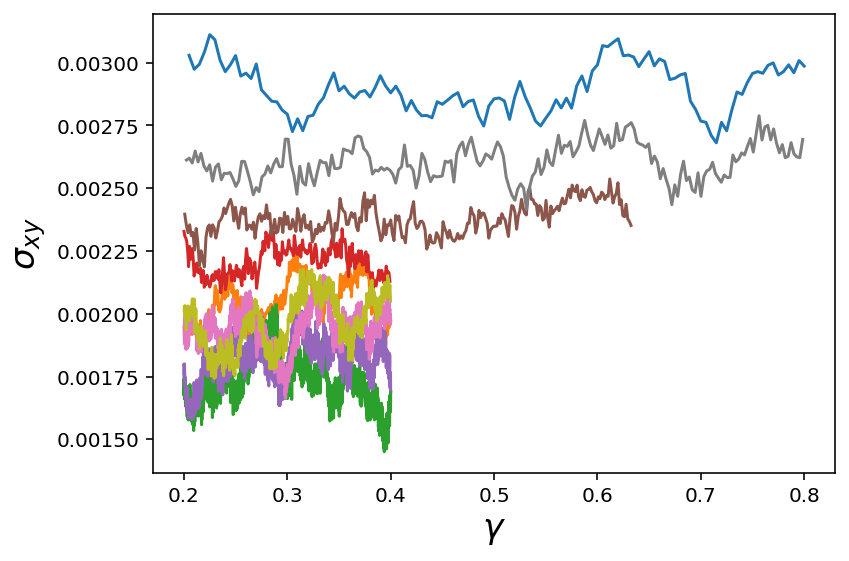

In [9]:
from scipy.ndimage import uniform_filter1d

plt.figure(tight_layout=True)

for s, fs in res.items():
    sigmas = []
    for f in fs:
        traj = gsd.hoomd.open(f, "rb")
        sigma_xy = np.array([snap.log["md/compute/ThermodynamicQuantities/pressure_tensor"][1] for snap in traj])
        sigmas.append(-sigma_xy)
    sigmas = np.mean(sigmas, axis=0)
    xy = np.array([snap.configuration.box[3] for snap in traj])
    # plt.plot(xy, uniform_filter1d(sigmas, 5))
    cond = xy > 0.2
    plt.plot(xy[cond], sigmas[cond])
# plt.yscale('log')
# plt.xscale('log')
plt.ylabel(r"$\sigma_{xy}$", size="xx-large")
plt.xlabel(r"$\gamma$", size="xx-large")
plt.savefig("cs_050523_fig2.png")

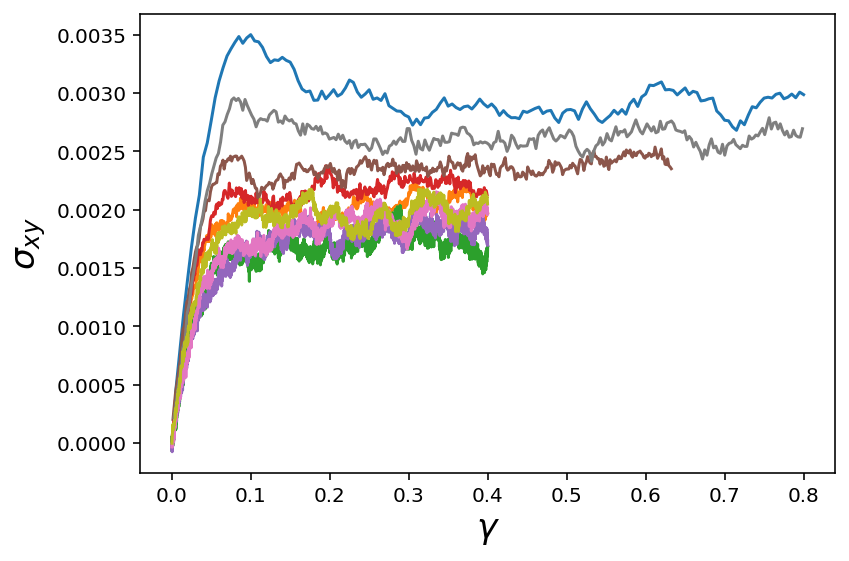

In [10]:
from scipy.ndimage import uniform_filter1d

plt.figure(tight_layout=True)

for s, fs in res.items():
    sigmas = []
    for f in fs:
        traj = gsd.hoomd.open(f, "rb")
        sigma_xy = np.array([snap.log["md/compute/ThermodynamicQuantities/pressure_tensor"][1] for snap in traj])
        sigmas.append(-sigma_xy)
    sigmas = np.mean(sigmas, axis=0)
    xy = np.array([snap.configuration.box[3] for snap in traj])
    # plt.plot(xy, uniform_filter1d(sigmas, 5))
    plt.plot(xy, sigmas)
# plt.yscale('log')
# plt.xscale('log')
plt.ylabel(r"$\sigma_{xy}$", size="xx-large")
plt.xlabel(r"$\gamma$", size="xx-large")
plt.savefig("cs_050523_fig3.png")